

```
# Isto está formatado como código
```

# **Session 02: Predicting stock market index using LSTM**

**Disclaimer**: Originally based on work by Hum Nath Bhandari, Binod Rimal, Nawa Raj Pokhrel, Ramchandra Rimal, Keshav Dahal, and Rajendra K.C. Khatri


# **Part I:  Data Creation and Exploration**

In this module we use various financial resources to create input data for our machine learning models. This includes the following data.
- S\&P 500 index data: Open price and Close price
- Vix index
- Interest Rate
- Unemployment Rate
- Consumer sentiment index
- Dollar Index
- MACD
- RSI
- ATR

Our data will be the time series data with the following start and end date.

- start date: adjustable
- end date:  last day the market was open (NYSE)


### **Importing basic libraries and APIs**

In [ ]:

import pandas as pd  ##import necessary libraries
import numpy as np
import math
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')


import tensorflow as tf
%load_ext tensorboard

import warnings
warnings.filterwarnings('ignore')

import os
import datetime as dt

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## **Loading input data**

---



In [ ]:
url = 'https://raw.githubusercontent.com/luiscunhacsc/course_dl_datasets/main/sp500_data.csv'
data = pd.read_csv(url)

data['Date']=pd.to_datetime(data['Date']).dt.date
data.set_index("Date",inplace=True)
data = data.iloc[:, 1:]
data.head()

,Close,MACD,RSI,ATR,VIX,USDX,EFFR,UNRATE,UMCSENT
Date,,,,,,,,,
1990-01-04,355.670013,2.801471,61.355763,3.521595,19.219999,92.519997,8.29,5.4,90.5
1990-01-05,352.200012,2.600547,54.708974,3.578625,20.110001,92.849998,8.20,5.4,90.5
1990-01-08,353.790009,2.540330,57.007254,3.587293,20.260000,92.050003,8.27,5.4,90.5
1990-01-09,349.619995,2.131551,49.861010,3.656774,22.200001,92.349998,8.25,5.4,90.5
1990-01-10,347.309998,1.602718,46.391673,3.774146,22.440001,92.389999,8.12,5.4,90.5


In [ ]:
data.tail()

,Close,MACD,RSI,ATR,VIX,USDX,EFFR,UNRATE,UMCSENT
Date,,,,,,,,,
2023-03-14,3919.290039,-34.979528,42.564898,64.175317,23.730000,103.599998,4.58,3.6,59.7
2023-03-15,3891.929932,-37.188349,40.186559,65.380655,26.139999,104.650002,4.58,3.6,59.7
2023-03-16,3960.280029,-33.042678,48.002960,67.878455,22.990000,104.419998,4.58,3.6,59.7
2023-03-17,3916.639893,-32.899356,44.045293,67.244995,25.510000,103.709999,4.58,3.6,59.7
2023-03-20,3951.570068,-29.625692,47.757998,65.297511,24.150000,103.279999,4.58,3.6,59.7


In [ ]:
print(data.shape)

(8366, 9)


In [ ]:
output_dir_path = "results/"

### **Data Exploration**

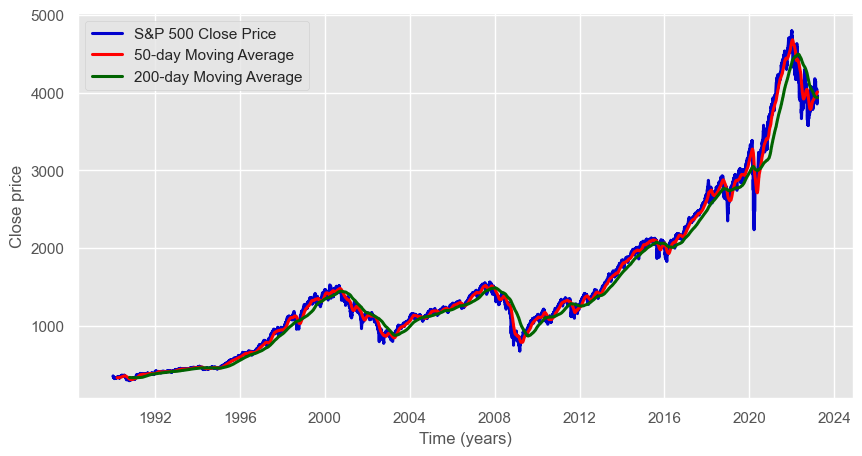

In [ ]:
df = data.copy()
df['MA_50'] = df['Close'].rolling(50).mean()
df['MA_200'] = df['Close'].rolling(200).mean()

fig = plt.figure(figsize=(10,5))
fig.set(facecolor = "white")
plt.plot(df['Close'], 'mediumblue',label=['S&P 500 Close Price'], linewidth = 2.2)
plt.plot(df['MA_50'],'red', label=['50-day MA'], linewidth = 2.2)
plt.plot(df['MA_200'],'darkgreen', label=['200-day MA'], linewidth = 2.2)
plt.legend(['S&P 500 Close Price', '50-day Moving Average', '200-day Moving Average'], loc='upper left')
plt.title('')
plt.xlabel('Time (years)')
plt.ylabel('Close price')
fig.savefig(output_dir_path+ "original_data_plus_moving_averages.png",dpi=600)
plt.show()

####  **Correlation heatmap**

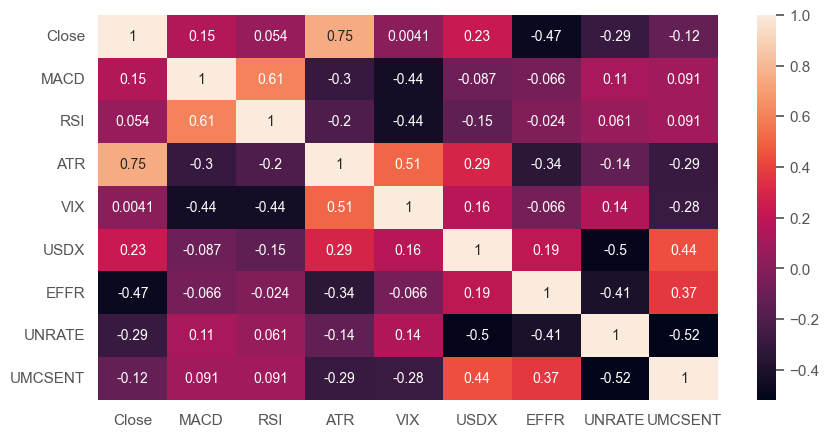

In [ ]:
fig = plt.figure(figsize= (10,5))
sns.heatmap(data.corr(), annot=True)
sns.set_style("whitegrid")
fig.savefig(output_dir_path+"correlation_heatmap2.png",dpi=600)
plt.show()

<Figure size 2000x1200 with 0 Axes>

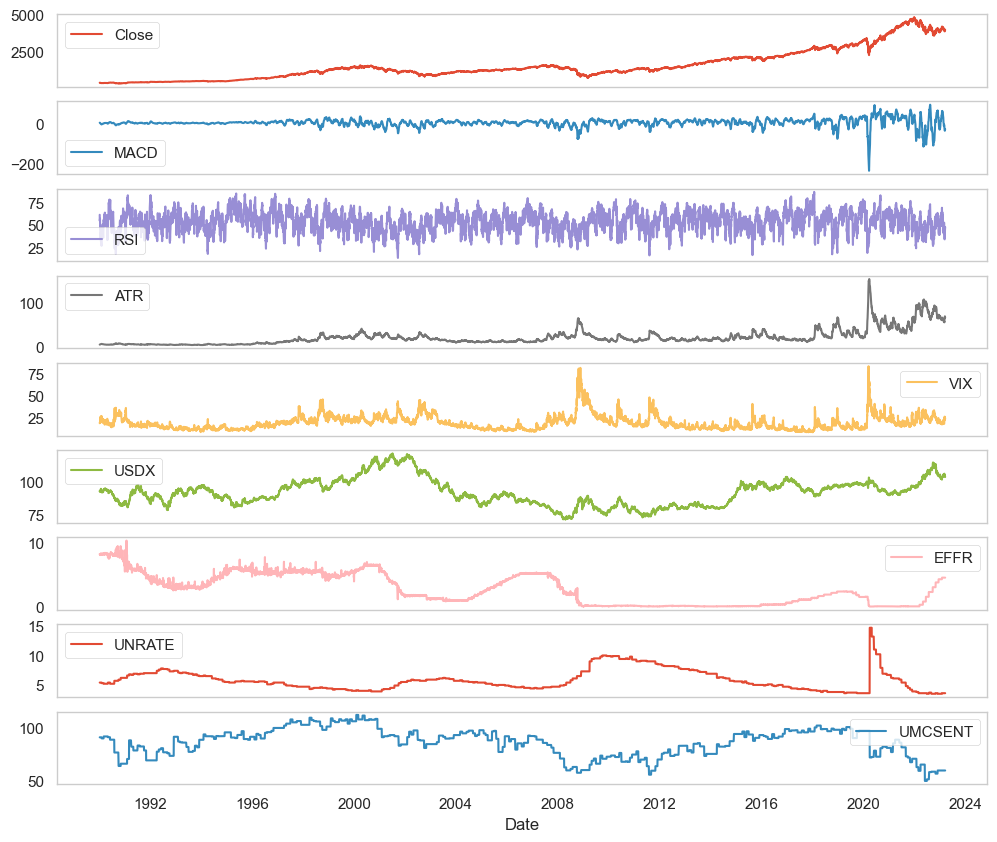

In [ ]:
fig = plt.figure(figsize = (20, 12))
data.plot(subplots = True, figsize = (12,10),grid=False)
sns.set_style("whitegrid")
fig.savefig(output_dir_path+"timeseries.png",dpi=600)
plt.show()

In [ ]:
data.describe()

,Close,MACD,RSI,ATR,VIX,USDX,EFFR,UNRATE,UMCSENT
count,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000,8366.000000
mean,1518.820129,3.053094,54.131646,19.979702,19.671969,91.629708,2.726672,5.814188,85.855283
std,1014.056865,20.639833,11.319329,18.250753,7.971605,9.991952,2.374665,1.741200,12.894407
min,295.459991,-237.020227,13.639346,2.402838,9.140000,71.330002,0.040000,3.500000,50.000000
25%,883.992493,-2.741943,46.026753,9.843544,13.910000,83.809998,0.190000,4.500000,76.400000
50%,1256.350037,3.487541,54.928066,15.343208,17.879999,91.250000,2.190000,5.500000,88.500000
75%,1973.167511,12.283873,62.402410,23.326028,23.139999,97.349998,5.137500,6.800000,95.300000
max,4796.560059,92.583711,86.686650,152.756467,82.690002,120.900002,10.390000,14.700000,111.300000


Epoch 1/50
4/4 [==============================] - 6s 996ms/step - loss: 0.0341
Epoch 2/50
4/4 [==============================] - 4s 1s/step - loss: 0.0118
Epoch 3/50
4/4 [==============================] - 5s 1s/step - loss: 0.0088
Epoch 4/50
4/4 [==============================] - 4s 1s/step - loss: 0.0067
Epoch 5/50
4/4 [==============================] - 4s 1s/step - loss: 0.0033
Epoch 6/50
4/4 [==============================] - 4s 1s/step - loss: 0.0032
Epoch 7/50
4/4 [==============================] - 5s 1s/step - loss: 0.0022
Epoch 8/50
4/4 [==============================] - 5s 1s/step - loss: 0.0013
Epoch 9/50
4/4 [==============================] - 5s 1s/step - loss: 0.0010
Epoch 10/50
4/4 [==============================] - 5s 1s/step - loss: 8.6729e-04
Epoch 11/50
4/4 [==============================] - 5s 1s/step - loss: 6.1037e-04
Epoch 12/50
4/4 [==============================] - 5s 1s/step - loss: 4.2283e-04
Epoch 13/50
4/4 [==============================] - 5s 1s/step - loss: 

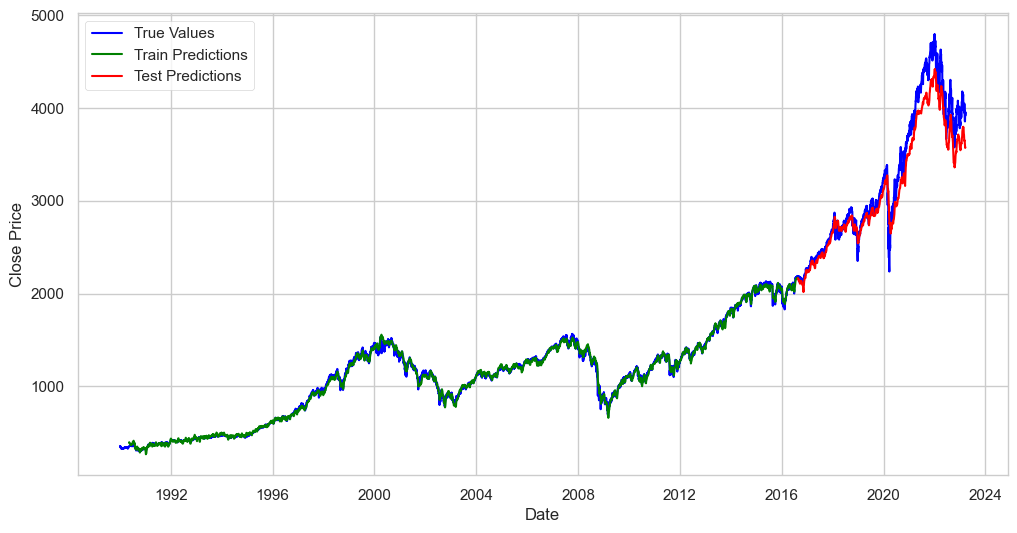

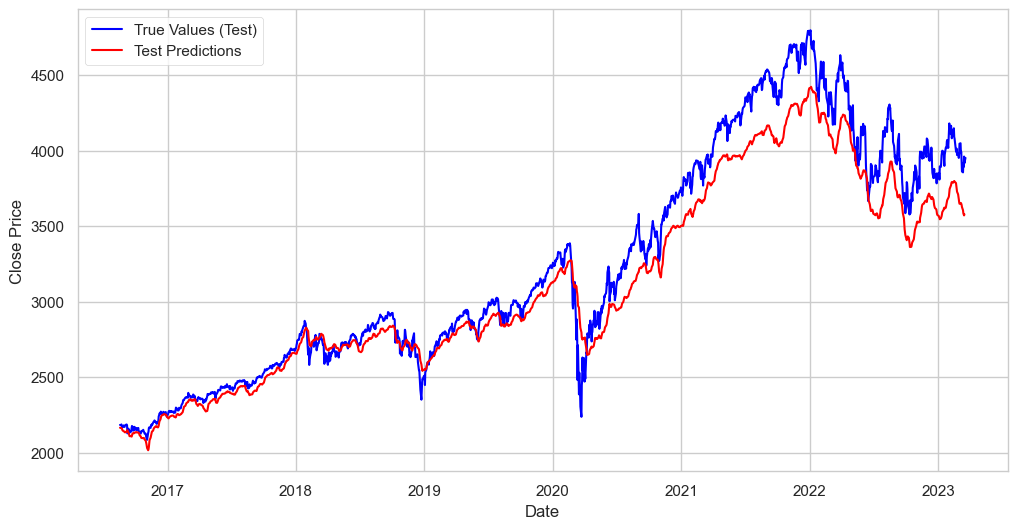

In [ ]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 2. Prepare the data
# Assuming your dataset is a pandas DataFrame named 'data'
# data = pd.read_csv("your_dataset.csv")
dates = data.index  # Store date information for plotting

# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Define a function to create sequences of input data and labels


def create_sequences(data, sequence_length, target_column):
    x, y = [], []
    for i in range(len(data) - sequence_length - 1):
        x.append(data[i: i + sequence_length])
        y.append(data[i + sequence_length, target_column])
    return np.array(x), np.array(y)


# Create input sequences and labels
sequence_length = 90  # Using one-day sequence to predict the next day's closing price
target_column = 0  # Assuming 'Close' is the first column in the dataset
x, y = create_sequences(data_scaled, sequence_length, target_column)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, shuffle=False)

# 3. Define the LSTM model using the functional API
input_layer = Input(shape=(sequence_length, data.shape[1]))
lstm_layer = LSTM(150)(input_layer)
output_layer = Dense(1)(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# 4. Compile and train the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mean_squared_error")

batch_size = 2048
epochs = 50  # Adjust the number of epochs according to your needs
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

# 5. Make predictions and plot the results
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Inverse-transform the scaled data back to the original scale
y_train_true = scaler.inverse_transform(np.hstack(
    (y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data.shape[1] - 1)))))
y_test_true = scaler.inverse_transform(np.hstack(
    (y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1)))))
y_train_pred = scaler.inverse_transform(np.hstack(
    (y_train_pred, np.zeros((y_train_pred.shape[0], data.shape[1] - 1)))))
y_test_pred = scaler.inverse_transform(
    np.hstack((y_test_pred, np.zeros((y_test_pred.shape[0], data.shape[1] - 1)))))

# Plot the true values and predictions
plt.figure(figsize=(12, 6))
plt.plot(dates, data['Close'], label='True Values', color='blue')
plt.plot(dates[sequence_length:len(y_train) + sequence_length],
         y_train_pred[:, 0], label='Train Predictions', color='green')
plt.plot(dates[len(y_train) + sequence_length:len(y_train) + len(y_test) +
         sequence_length], y_test_pred[:, 0], label='Test Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot only the true values and test predictions
plt.figure(figsize=(12, 6))
plt.plot(dates[len(y_train) + sequence_length:], data['Close'][len(y_train) + sequence_length:], label='True Values (Test)', color='blue')
plt.plot(dates[len(y_train) + sequence_length:len(y_train) + len(y_test) + sequence_length], y_test_pred[:, 0], label='Test Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
